In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class SinusoidNetwork(nn.Module):
    def __init__(self,input_dim,hidden_units):
        super(SinusoidNetwork,self).__init__()
        self.net= nn.Sequential(
            nn.Linear(input_dim,hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,1)
        )
    def forward(self,x):
        return self.net(x)

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np


# In[2]:


def train_model(train_data, loss_fn, lr, model_class, model_kwargs,
                X_test, max_epochs, device, batch_size, patience=10,model_idx=0):
    X_train_resampled, y_train_resampled = train_data
    train_loss=[]
    print(f"\n--- Training Model {model_idx+1} ---")
    # Split into train/val for early stopping
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
    )

    X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val_split, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_split, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = model_class(**model_kwargs).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None

    for epoch in range(max_epochs):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        avg_epoch_loss = epoch_loss / len(train_dataset)
        train_loss.append(avg_epoch_loss)

        # validation
        model.eval()
        with torch.no_grad():
            val_out = model(X_val_tensor)
            val_loss = loss_fn(val_out, y_val_tensor).item()
        print(f'Epoch {epoch+1}/{max_epochs}, Avg Train Loss: {epoch_loss/len(train_dataset):.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_weights = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # reload best
    model.load_state_dict(best_weights)
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu()
    return preds,train_loss


# In[3]:


def get_bvd_mse(all_preds, y_test):
    mean_preds = all_preds.mean(dim=0)
    bias2 = torch.mean((mean_preds - y_test) ** 2)
    variance = torch.mean((all_preds - mean_preds.unsqueeze(0)) ** 2)
    return bias2.item(), variance.item()


# In[4]:


def estimate_bias_variance_mse(model_class, X_train, y_train, X_test, y_test,
                               model_kwargs={}, num_models=5, max_epochs=100,
                               patience=10, batch_size=64, lr=0.01,
                               device='cpu', sampling="bootstrap"):
    N = X_train.shape[0]
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    all_preds = []
    for i in range(num_models):
        # --- On-the-fly bootstrap resample ---
        print(f" Training model {i+1}")
        if sampling == "bootstrap":
            indices = np.random.choice(N, size=N, replace=True)
            X_resampled, y_resampled = X_train[indices], y_train[indices]
        else:
            X_resampled, y_resampled = X_train, y_train

        # Train on resampled data
        preds,train_loss = train_model((X_resampled, y_resampled), nn.MSELoss(), lr,
                            model_class, model_kwargs, X_test,
                            max_epochs, device, batch_size, patience, model_idx=i)
        all_preds.append(preds)

    all_preds = torch.stack(all_preds)  # [M, N, 1]
    avg_train_loss = np.mean(train_loss,axis=0)
    bias2, var = get_bvd_mse(all_preds, y_test_tensor)
    mse = torch.mean((all_preds - y_test_tensor.unsqueeze(0)) ** 2).item()

    print(f"\n--- Final Results (MSE) ---")
    print(f"Bias²:    {bias2:.4f}")
    print(f"Variance: {var:.4f}")
    print(f"MSE:      {mse:.4f}")
    print(f"Bias²+Var:{bias2+var:.4f}")
    return bias2, var, mse,avg_train_loss

In [40]:
learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

In [41]:
def generate_sinusoid_data(num_samples:int,noise_scale:float=0.2):
    X = np.linspace(-1,1,num_samples).reshape(-1, 1)
    y_true = np.sin(2 * np.pi * X)                       # shape: (num_samples, 1)
    noise = np.random.normal(0, noise_scale, size=(num_samples, 1))#random gaussian noise
    y = y_true + noise
    return X,y

In [42]:
X_train,y_train = generate_sinusoid_data(num_samples=80)
X_test,y_test = generate_sinusoid_data(num_samples=200,noise_scale=0)

In [43]:
NUM_TRAIN_SAMPLES = 80
NUM_TEST_SAMPLES = 1000
NOISE_SCALE = 0.2
NUM_BOOTSTRAP_MODELS = 30
MAX_EPOCHS = 500
PATIENCE = 1000
LEARNING_RATE = 0.001

In [44]:
X_train, y_train = generate_sinusoid_data(num_samples=NUM_TRAIN_SAMPLES, noise_scale=NOISE_SCALE)
X_test, y_test = generate_sinusoid_data(num_samples=NUM_TEST_SAMPLES, noise_scale=0)

In [45]:
results = []
for lr in learning_rates:
    print(f"\n*** Running experiment for network with {lr} learning rates ***")
    bias, variance, mse,avg_train_loss = estimate_bias_variance_mse(
            model_class=SinusoidNetwork,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            model_kwargs={'input_dim':1,"hidden_units":512},
            num_models=NUM_BOOTSTRAP_MODELS,
            max_epochs=MAX_EPOCHS,
            patience=PATIENCE,
            lr=lr
        )
    results.append({
            'bias': bias,
            'variance': variance,
            'total_error': mse,
            'bias_plus_variance': bias+variance,
            'lr':lr,
            'avg_train_loss':avg_train_loss
        })


Streaming output truncated to the last 5000 lines.
Epoch 34/500, Avg Train Loss: 0.6868, Val Loss: 1.2079
Epoch 35/500, Avg Train Loss: 0.7111, Val Loss: 1.1643
Epoch 36/500, Avg Train Loss: 0.7225, Val Loss: 1.1304
Epoch 37/500, Avg Train Loss: 0.7132, Val Loss: 1.0990
Epoch 38/500, Avg Train Loss: 0.6840, Val Loss: 1.0718
Epoch 39/500, Avg Train Loss: 0.6412, Val Loss: 1.0526
Epoch 40/500, Avg Train Loss: 0.5939, Val Loss: 1.0461
Epoch 41/500, Avg Train Loss: 0.5514, Val Loss: 1.0540
Epoch 42/500, Avg Train Loss: 0.5197, Val Loss: 1.0730
Epoch 43/500, Avg Train Loss: 0.5013, Val Loss: 1.0990
Epoch 44/500, Avg Train Loss: 0.4950, Val Loss: 1.1248
Epoch 45/500, Avg Train Loss: 0.4965, Val Loss: 1.1429
Epoch 46/500, Avg Train Loss: 0.5004, Val Loss: 1.1471
Epoch 47/500, Avg Train Loss: 0.5018, Val Loss: 1.1339
Epoch 48/500, Avg Train Loss: 0.4975, Val Loss: 1.1032
Epoch 49/500, Avg Train Loss: 0.4865, Val Loss: 1.0581
Epoch 50/500, Avg Train Loss: 0.4703, Val Loss: 1.0036
Epoch 51/500, 

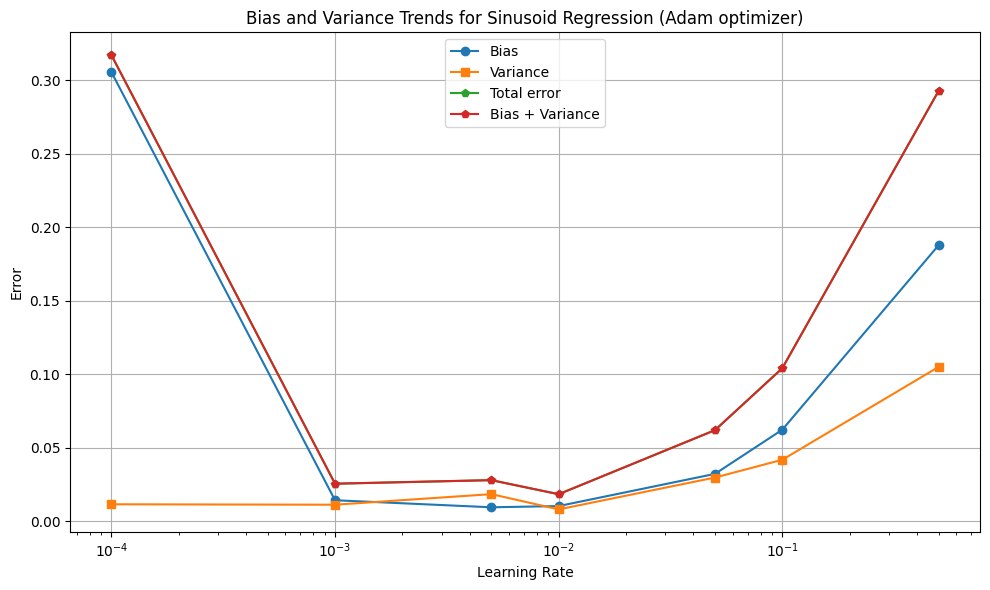

In [46]:
import numpy as np

# Convert to numpy arrays for easier sorting
bias_values = np.array([res['bias'] for res in results])
variance_values = np.array([res['variance'] for res in results])
error_values = np.array([res['total_error'] for res in results])
bias_plus_variance = np.array([res['bias_plus_variance'] for res in results])


# Plot again
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, bias_values, marker='o', label='Bias')
plt.plot(learning_rates, variance_values, marker='s', label='Variance')
plt.plot(learning_rates, error_values, marker='p', label='Total error')
plt.plot(learning_rates, bias_plus_variance, marker='p', label='Bias + Variance')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression (Adam optimizer)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
second_results = []
for lr in learning_rates:
    print(f"\n*** Running experiment for network with {lr} learning rates ***")
    bias, variance, mse,avg_train_loss = estimate_bias_variance_mse(
            model_class=SinusoidNetwork,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            model_kwargs={'input_dim':1,"hidden_units":512},
            num_models=NUM_BOOTSTRAP_MODELS,
            max_epochs=MAX_EPOCHS,
            patience=PATIENCE,
            lr=lr
        )
    second_results.append({
            'bias': bias,
            'variance': variance,
            'total_error': mse,
            'bias_plus_variance': bias+variance,
            'lr':lr,
            'avg_train_loss':avg_train_loss
        })

Streaming output truncated to the last 5000 lines.
Epoch 34/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 35/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 36/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 37/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 38/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 39/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 40/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 41/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 42/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 43/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 44/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 45/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 46/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 47/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 48/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 49/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 50/500, Avg Train Loss: 0.4313, Val Loss: 0.4833
Epoch 51/500, 

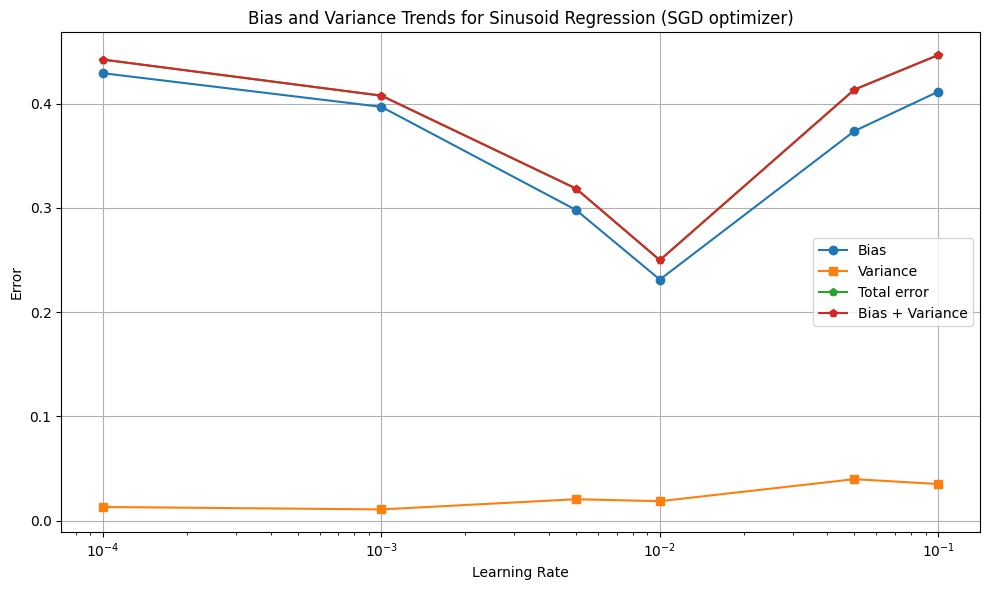

In [54]:
import numpy as np

# Convert to numpy arrays for easier sorting
bias_values = np.array([res['bias'] for res in second_results])
variance_values = np.array([res['variance'] for res in second_results])
error_values = np.array([res['total_error'] for res in second_results])
bias_plus_variance = np.array([res['bias_plus_variance'] for res in second_results])



# Plot again
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, bias_values, marker='o', label='Bias')
plt.plot(learning_rates, variance_values, marker='s', label='Variance')
plt.plot(learning_rates, error_values, marker='p', label='Total error')
plt.plot(learning_rates, bias_plus_variance, marker='p', label='Bias + Variance')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression (SGD optimizer)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
results = []
for lr in learning_rates:
    print(f"\n*** Running experiment for network with {lr} learning rates ***")
    bias, variance, mse = estimate_bias_variance_mse(
            model_class=SinusoidNetwork,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            model_kwargs={'input_dim':1,"hidden_units":256},
            num_models=NUM_BOOTSTRAP_MODELS,
            max_epochs=MAX_EPOCHS,
            patience=PATIENCE,
            lr=lr
        )
    results.append({
            'bias': bias,
            'variance': variance,
            'total_error': mse,
            'bias_plus_variance': bias+variance,
            'lr':lr
        })


Streaming output truncated to the last 5000 lines.
Epoch 34/500, Avg Train Loss: 1.1446, Val Loss: 0.8628
Epoch 35/500, Avg Train Loss: 1.2292, Val Loss: 0.8499
Epoch 36/500, Avg Train Loss: 1.1807, Val Loss: 0.8037
Epoch 37/500, Avg Train Loss: 1.0322, Val Loss: 0.7414
Epoch 38/500, Avg Train Loss: 0.8364, Val Loss: 0.6787
Epoch 39/500, Avg Train Loss: 0.6469, Val Loss: 0.6271
Epoch 40/500, Avg Train Loss: 0.5034, Val Loss: 0.5923
Epoch 41/500, Avg Train Loss: 0.4272, Val Loss: 0.5749
Epoch 42/500, Avg Train Loss: 0.4179, Val Loss: 0.5712
Epoch 43/500, Avg Train Loss: 0.4588, Val Loss: 0.5744
Epoch 44/500, Avg Train Loss: 0.5243, Val Loss: 0.5804
Epoch 45/500, Avg Train Loss: 0.5881, Val Loss: 0.5851
Epoch 46/500, Avg Train Loss: 0.6300, Val Loss: 0.5857
Epoch 47/500, Avg Train Loss: 0.6399, Val Loss: 0.5819
Epoch 48/500, Avg Train Loss: 0.6181, Val Loss: 0.5750
Epoch 49/500, Avg Train Loss: 0.5734, Val Loss: 0.5673
Epoch 50/500, Avg Train Loss: 0.5185, Val Loss: 0.5608
Epoch 51/500, 

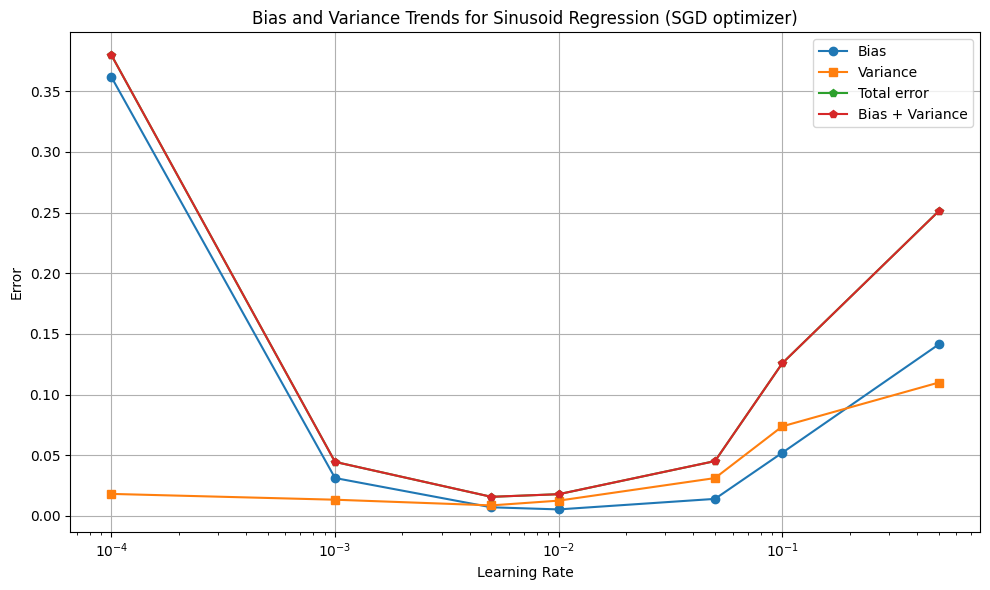

In [ ]:
import numpy as np

# Convert to numpy arrays for easier sorting
learning_rates = np.array([0.0001, 0.001, 0.005, 0.05, 0.01, 0.1, 0.5])
bias_values = np.array([res['bias'] for res in results])
variance_values = np.array([res['variance'] for res in results])
error_values = np.array([res['total_error'] for res in results])
bias_plus_variance = np.array([res['bias_plus_variance'] for res in results])

# Sort indices based on learning_rates
sorted_indices = np.argsort(learning_rates)

# Apply sorting
learning_rates = learning_rates[sorted_indices]
bias_values = bias_values[sorted_indices]
variance_values = variance_values[sorted_indices]
error_values = error_values[sorted_indices]
bias_plus_variance = bias_plus_variance[sorted_indices]

# Plot again
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, bias_values, marker='o', label='Bias')
plt.plot(learning_rates, variance_values, marker='s', label='Variance')
plt.plot(learning_rates, error_values, marker='p', label='Total error')
plt.plot(learning_rates, bias_plus_variance, marker='p', label='Bias + Variance')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression (SGD optimizer)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

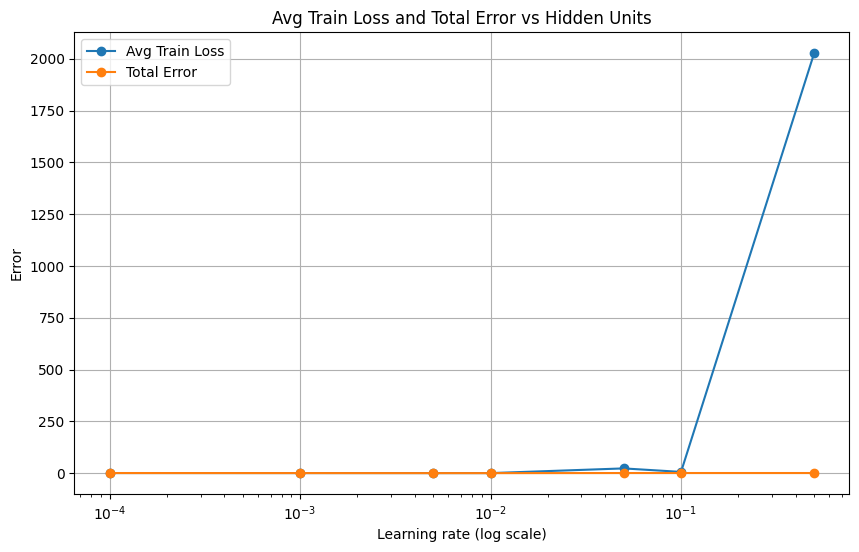

In [28]:
error_values = [res['total_error'] for res in second_results]
avg_train_loss = [r['avg_train_loss'] for r in second_results]
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(learning_rates, error_values, marker='o', label='Total Error')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('Learning rate (log scale)')
plt.ylabel('Error')
plt.title('Avg Train Loss and Total Error vs Hidden Units')
plt.legend()
plt.grid(True)
plt.show()